<a href="https://colab.research.google.com/github/sarvan0506/AI/blob/Dev/Assignment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Image Augumentation using Cut-out and Implementing GradCAM to analyze the effect of Cut-out.

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import cv2

In [2]:

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


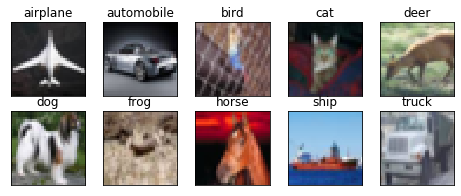

In [3]:

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Pick 4 images from the dataset for inspection

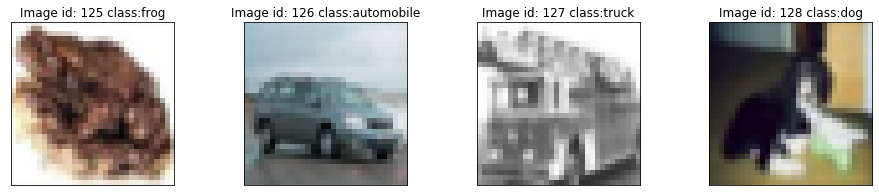

In [7]:
img_no = 4
rand_id = 125

fig = plt.figure(figsize=(16,3))
for i in range(img_no):
  ax = fig.add_subplot(1, 4, 1 + i, xticks=[], yticks=[])
  ax.set_title("Image id: " + str(rand_id + i) + " class:" + class_names[np.argmax(train_labels[rand_id + i])])
  plt.imshow(train_features[rand_id + i])
plt.show()


In [8]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3))) # output 32
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) # output 32
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2))) # output 16
model.add(Dropout(0.2))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) # output 16
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) # output 16
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2))) # output 8
model.add(Dropout(0.3))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) # output 8
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) # output 8
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2))) # output 4
model.add(Dropout(0.5))

model.add(Convolution2D(4, 1))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(10, 4))
model.add(Flatten())


model.add(Activation('softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  # Remove the CWD from sys.path while we load stuff.




Epoch 1/50
390/390 [==============================] - 16s 40ms/step - loss: 1.4993 - acc: 0.4682 - val_loss: 1.3643 - val_acc: 0.5382
Epoch 2/50
390/390 [==============================] - 10s 25ms/step - loss: 1.0408 - acc: 0.6477 - val_loss: 0.9738 - val_acc: 0.6761
Epoch 3/50
390/390 [==============================] - 10s 25ms/step - loss: 0.8716 - acc: 0.7138 - val_loss: 0.8827 - val_acc: 0.7111
Epoch 4/50
390/390 [==============================] - 10s 25ms/step - loss: 0.7801 - acc: 0.7498 - val_loss: 0.7799 - val_acc: 0.7482
Epoch 5/50
390/390 [==============================] - 10s 25ms/step - loss: 0.7115 - acc: 0.7764 - val_loss: 0.8320 - val_acc: 0.7466
Epoch 6/50
390/390 [==============================] - 10s 25ms/step - loss: 0.6648 - acc: 0.7950 - val_loss: 0.7220 - val_acc: 0.7796
Epoch 7/50
390/390 [==============================] - 10s 25ms/step - loss: 0.6321 - acc: 0.8088 - val_loss: 0.7052 - val_acc: 0.7903
Epoch 8/50
390/390 [==============================] - 10s 25

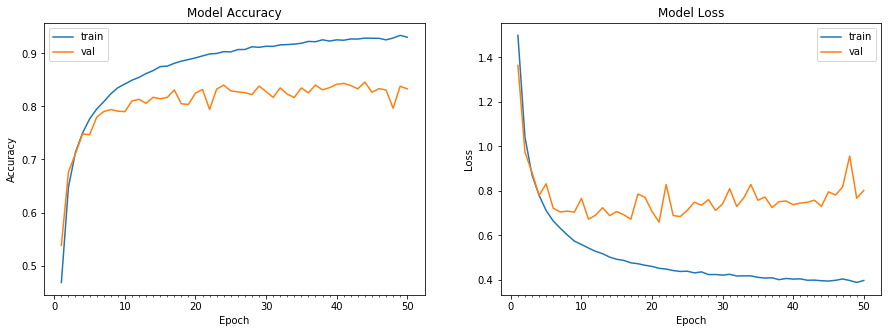

Accuracy on test data is: 83.31


In [9]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#### Implementing GradCAM

In [20]:
x.reshape(1,32,32,3)

array([[[[1.        , 1.        , 1.        ],
         [0.9843137 , 0.9764706 , 0.9882353 ],
         [0.9843137 , 0.98039216, 0.9882353 ],
         ...,
         [0.9882353 , 0.9882353 , 0.9882353 ],
         [0.9843137 , 0.9843137 , 0.9843137 ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [0.98039216, 0.99607843, 0.99607843],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [0.99607843, 0.99607843, 0.99607843],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [0.9764706 , 0.99215686, 0.9764706 ],
         [0.92156863, 0.90588236, 0.8862745 ],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [0.99607843, 0.99607843, 0.99607843]

In [0]:
x = train_features[125].reshape(1,32,32,3)
x = preprocess_input(x)
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]

conv_layer = model.get_layer("conv2d_8") # interested layer of inspection

grads = K.gradients(class_output, conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [60]:
class_output

<tf.Tensor 'strided_slice_8:0' shape=(?,) dtype=float32>

In [41]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [45]:
superimposed_img = cv2.addWeighted(train_features[125], 0.6, heatmap, 0.4, 0)
cv2.imshow("GradCam", superimposed_img)
cv2.waitKey(0)

error: ignored

In [36]:
np.argmax(model.predict(test_features[124].reshape(1, 32, 32, 3)))

8

In [37]:
np.argmax(test_labels[124])

8

In [39]:
conv_layer_output_value.shape

(8, 8, 256)